<a href="https://colab.research.google.com/github/PondKann/CXR-Project/blob/main/TrainTest_2_3class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### import

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import pandas as pd
from torchsummary import summary
from skimage.io import imread, imsave
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from imutils import paths
import argparse

from sklearn.model_selection import KFold
from sklearn import metrics
from scipy.stats import zscore

#### Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/My Drive/Senior Project/CXR Image3class'

train 3 class

In [5]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

#### test 3 class  --- สร้างตารางเก็บ ชื่อภาพ และชื่อคลาส
ข้อมูลใน All_3class_dir รวมภาพทั้ง 3 คลาส รวม 451 ภาพ TB150, Normal151 และ CA150 (CA คือ lungcancer)

In [6]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

In [7]:
normal = []
for i in range(len(os.listdir(Normal151_dir))):
    img = os.listdir(Normal151_dir)[i]
    normal.append(img)
    
tnormal = pd.DataFrame({'ImageName':[normal][0],
                                       'NameType': "Normal" ,
                                       'NumberType': 0                      })

In [8]:
tuberculosis = []
for i in range(len(os.listdir(TB150_dir))):
    img = os.listdir(TB150_dir)[i]
    tuberculosis.append(img)

ttuberculosis = pd.DataFrame({'ImageName':[tuberculosis][0],
                                       'NameType': "Tuberculosis" ,
                                       'NumberType': 1                        })

In [9]:
lungcancer = []
for i in range(len(os.listdir(CA150_dir))):
    img = os.listdir(CA150_dir)[i]
    lungcancer.append(img)

tlungcancer = pd.DataFrame({'ImageName':[lungcancer][0],
                                       'NameType': "Lungcancer" ,
                                       'NumberType': 2                        })

In [10]:
data_train2 = pd.concat([tnormal, ttuberculosis])
data_train2.head(3)

,ImageName,NameType,NumberType
0,124.jpg,Normal,0
1,128.jpg,Normal,0
2,151.jpg,Normal,0


In [11]:
data_train3 = pd.concat([tnormal, ttuberculosis, tlungcancer])
data_train3[-3:]

,ImageName,NameType,NumberType
147,ca26.jpg,Lungcancer,2
148,ca7.jpg,Lungcancer,2
149,ca8.jpg,Lungcancer,2


#### ครอปภาพ

In [12]:
import PIL
from PIL import Image

In [13]:
data_train3[:5]

,ImageName,NameType,NumberType
0,124.jpg,Normal,0
1,128.jpg,Normal,0
2,151.jpg,Normal,0
3,146.jpg,Normal,0
4,138.jpg,Normal,0


In [34]:
#ครอปภาพได้
mywidth = 224

img9 = Image.open(All_3class_dir + '/'+'124.jpg')
wpercent = (mywidth/float(img9.size[0]))
hsize = int((float(img9.size[1])*float(wpercent)))
img = img9.resize((mywidth,hsize), PIL.Image.ANTIALIAS)
img.size

(224, 250)

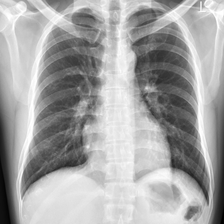

In [35]:
img_c = img.crop((0,0,224,224))
img_c

In [ ]:
#ลองดูว่าปกติ dim เป็นแบบไหน
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

In [45]:
img9 = cv2.imread(All_3class_dir + '/'+'124.jpg')
img9.shape   #shape (719, 643, 3)

(719, 643, 3)

In [46]:
#ถ้าแบบ cv2 ลองทำครอบ
wpercent = (mywidth/float(img9.size[0]))
hsize = int((float(img9.size[1])*float(wpercent)))
img = img9.resize((mywidth,hsize), PIL.Image.ANTIALIAS)

TypeError: ignored

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
x = img_to_array(img_c)
x

In [44]:
xcv = img_to_array(img)
xcv

array([[[207., 207., 207.],
        [207., 207., 207.],
        [209., 209., 209.],
        ...,
        [196., 196., 196.],
        [194., 194., 194.],
        [192., 192., 192.]],

       [[209., 209., 209.],
        [208., 208., 208.],
        [206., 206., 206.],
        ...,
        [189., 189., 189.],
        [191., 191., 191.],
        [194., 194., 194.]],

       [[203., 203., 203.],
        [205., 205., 205.],
        [204., 204., 204.],
        ...,
        [191., 191., 191.],
        [196., 196., 196.],
        [201., 201., 201.]],

       ...,

       [[ 20.,  20.,  20.],
        [ 20.,  20.,  20.],
        [ 19.,  19.,  19.],
        ...,
        [ 10.,  10.,  10.],
        [ 10.,  10.,  10.],
        [ 11.,  11.,  11.]],

       [[ 20.,  20.,  20.],
        [ 20.,  20.,  20.],
        [ 19.,  19.,  19.],
        ...,
        [ 10.,  10.,  10.],
        [ 10.,  10.,  10.],
        [ 11.,  11.,  11.]],

       [[ 20.,  20.,  20.],
        [ 20.,  20.,  20.],
        [ 19.,  

In [ ]:
#แปลงภาพเป็น array
image_sequence = img_c.getdata()
image_array = np.array(image_sequence)
image_array.shape

(54656,)

In [ ]:
len(ta2)

2

In [ ]:
data_Dense = np.array(ta2, dtype="float32") / 255.0

In [ ]:
data_Dense

array([[0.8117647 , 0.8117647 , 0.81960785, ..., 0.03921569, 0.03921569,
        0.04313726],
       [0.8117647 , 0.8117647 , 0.81960785, ..., 0.03921569, 0.03921569,
        0.04313726]], dtype=float32)

#แก้ขนาดภาพ เป็น 224 

In [ ]:
train_img_Dense = []
mywidth = 244 
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป

    img = Image.open(image_path)

    wpercent = (mywidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((mywidth,hsize), PIL.Image.ANTIALIAS)
    img = img.crop((0,0,mywidth,mywidth))
    
    img = img_to_array(img)
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [04:45<00:00,  1.58it/s]


ValueError: ignored

In [ ]:
train_img_Dense

####  test 3 class 
 TB  Normal จากเน็ต   และ CA จากข้อมูล

In [ ]:
TB700_dir = os.path.join(data_dir,'test_model/Tuberculosis700')
Normal94_dir = os.path.join(data_dir,'test_model/NORMAL94')
CA150_dir = os.path.join(data_dir,'CA150')                  #อันเดิมที่ใช้เทรน

AllTest_2class = os.path.join(data_dir,'test_model/AllTest_2class')

In [ ]:
#สำหรับ test model
normal = []
for i in range(len(os.listdir(Normal94_dir))):
    img = os.listdir(Normal94_dir)[i]
    normal.append(img)
    
tnormal94 = pd.DataFrame({'ImageName':[normal][0],
                                       'NameType': "Normal" ,
                                       'NumberType': 0                      })

In [ ]:
#สำหรับ test model
tb700 = []
for i in range(len(os.listdir(TB700_dir))):
    img = os.listdir(TB700_dir)[i]
    tb700.append(img)

ttb700 = pd.DataFrame({'ImageName':[tb700][0],
                                       'NameType': "Tuberculosis" ,
                                       'NumberType': 1                        })

In [ ]:
#สำหรับ test model ข้อม฿ลเดิม
lungcancer = []
for i in range(len(os.listdir(CA150_dir))):
    img = os.listdir(CA150_dir)[i]
    lungcancer.append(img)

tlungcancer = pd.DataFrame({'ImageName':[lungcancer][0],
                                       'NameType': "Lungcancer" ,
                                       'NumberType': 2                        })

In [ ]:
data_test2 = pd.concat([tnormal94[:30], ttb700[:30], tlungcancer[:10]])

In [ ]:
test_NorTB = []
for ImageName in tqdm(data_test2['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test2
    image_path = AllTest_2class +'/' + ImageName                          # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (299, 299))
    test_NorTB.append(img)

100%|██████████| 70/70 [00:19<00:00,  3.60it/s]


In [ ]:
data_test = np.array(test_NorTB, dtype="float32") / 255.0

labels_test = np.array(data_test2[['NameType']] )        
labels_test.shape = (len(labels_test),) 

le3_Incep = LabelEncoder()                                                                     
labels_test = le3_Incep.fit_transform(labels_test)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_test = to_categorical(labels_test, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

# Train Test หลังจากทำ K-fold

## 5) K-fold  -- DenseNet201

#### พารามิเตอร์จาก  '5) K-fold  -- DenseNet201' -->  ACC = 0.93, เวลา - นาที

*   BS = 16
*   fix weight & bias in layer 0-500
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [04:15<00:00,  1.76it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
le_Dense.classes_                  # มีค่า ['Lungcancer', 'Normal', 'Tuberculosis']

array(['Lungcancer', 'Normal', 'Tuberculosis'], dtype=object)

In [ ]:
INIT_LR = 1e-1
BS16 = 16
EPOCHS = 50

aug2 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

74850304/74836368 [==============================] - 0s 0us/step


707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:600]:    #fix w & bias in layer 0-600
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense2 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
H_Dense2 = model_Dense2.fit( x=aug2.flow(x_train_Dense2, y_train_Dense2, batch_size=BS16),
	                                            validation_data=(x_test_Dense2, y_test_Dense2),
	                                            steps_per_epoch=len(x_train_Dense2) // BS16,
	                                            epochs=30,  callbacks = [callback])

In [ ]:
#1
pred_Dense2 = model_Dense2.predict(x_test_Dense2)
    
print(classification_report(y_test_Dense2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                    pred_Dense2.argmax(axis=1),  
                                    target_names=le_Dense.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.78      0.60      0.68        35
      Normal       0.91      0.95      0.93        41
Tuberculosis       0.65      0.76      0.70        37

    accuracy                           0.78       113
   macro avg       0.78      0.77      0.77       113
weighted avg       0.78      0.78      0.78       113



In [ ]:
score = metrics.accuracy_score(y_test_Dense2.argmax(axis=1),	        #ค่า acc
                                             pred_Dense2.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

Fold score (accuracy): 0.7787610619469026


In [ ]:
#2 แค่เทรนใหม่ไม่ได้โหลดโมเดลใหม่
pred_Dense2 = model_Dense2.predict(x_test_Dense2)
    
print(classification_report(y_test_Dense2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                    pred_Dense2.argmax(axis=1),  
                                    target_names=le_Dense.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.77      0.57      0.66        35
      Normal       0.95      0.95      0.95        41
Tuberculosis       0.65      0.81      0.72        37

    accuracy                           0.79       113
   macro avg       0.79      0.78      0.78       113
weighted avg       0.80      0.79      0.78       113



In [ ]:
#3 แค่เทรนใหม่ไม่ได้โหลดโมเดลใหม่
pred_Dense2 = model_Dense2.predict(x_test_Dense2)
    
print(classification_report(y_test_Dense2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                    pred_Dense2.argmax(axis=1),  
                                    target_names=le_Dense.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.82      0.51      0.63        35
      Normal       0.95      0.88      0.91        41
Tuberculosis       0.60      0.86      0.71        37

    accuracy                           0.76       113
   macro avg       0.79      0.75      0.75       113
weighted avg       0.79      0.76      0.76       113



In [ ]:
#4 แค่เทรนใหม่ไม่ได้โหลดโมเดลใหม่ แค่width_shift_range=0.2, height_shift_range=0.2,
pred_Dense2 = model_Dense2.predict(x_test_Dense2)
    
print(classification_report(y_test_Dense2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                    pred_Dense2.argmax(axis=1),  
                                    target_names=le_Dense.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.74      0.66      0.70        35
      Normal       0.95      0.95      0.95        41
Tuberculosis       0.68      0.76      0.72        37

    accuracy                           0.80       113
   macro avg       0.79      0.79      0.79       113
weighted avg       0.80      0.80      0.80       113



## 5) K-fold  -- DenseNet201

#### พารามิเตอร์จาก  '5.1) K-fold  -- DenseNet201' -->  ACC = 0.93, เวลา - นาที

*   BS = 16
*   fix weight & bias in layer 0-500
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [04:15<00:00,  1.76it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
le_Dense.classes_                  # มีค่า ['Lungcancer', 'Normal', 'Tuberculosis']

array(['Lungcancer', 'Normal', 'Tuberculosis'], dtype=object)

In [ ]:
INIT_LR = 1e-1
BS16 = 16
EPOCHS = 50

aug51 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

74850304/74836368 [==============================] - 0s 0us/step


707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:600]:    #fix w & bias in layer 0-600
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense51 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense51.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
H_Dense51 = model_Dense51.fit( x=aug51.flow(x_train_Dense2, y_train_Dense2, batch_size=BS16),
	                                            validation_data=(x_test_Dense2, y_test_Dense2),
	                                            steps_per_epoch=len(x_train_Dense2) // BS16,
	                                            epochs=30,  callbacks = [callback])

Epoch 1/30
21/21 [==============================] - 146s 6s/step - loss: 0.4134 - accuracy: 0.7950 - val_loss: 0.3890 - val_accuracy: 0.7611
Epoch 2/30
21/21 [==============================] - 126s 6s/step - loss: 0.2447 - accuracy: 0.9472 - val_loss: 0.3561 - val_accuracy: 0.7611
Epoch 3/30
21/21 [==============================] - 125s 6s/step - loss: 0.2038 - accuracy: 0.9379 - val_loss: 0.3235 - val_accuracy: 0.8053
Epoch 4/30
21/21 [==============================] - 125s 6s/step - loss: 0.1505 - accuracy: 0.9658 - val_loss: 0.3735 - val_accuracy: 0.7876
Epoch 5/30
21/21 [==============================] - 125s 6s/step - loss: 0.1270 - accuracy: 0.9689 - val_loss: 0.3373 - val_accuracy: 0.7788
Epoch 6/30
21/21 [==============================] - 125s 6s/step - loss: 0.1194 - accuracy: 0.9752 - val_loss: 0.3547 - val_accuracy: 0.7788


In [ ]:
#1
pred_Dense2 = model_Dense51.predict(x_test_Dense2)
    
print(classification_report(y_test_Dense2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                    pred_Dense2.argmax(axis=1),  
                                    target_names=le_Dense.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.82      0.51      0.63        35
      Normal       0.97      0.90      0.94        41
Tuberculosis       0.62      0.89      0.73        37

    accuracy                           0.78       113
   macro avg       0.80      0.77      0.77       113
weighted avg       0.81      0.78      0.78       113



In [ ]:
score = metrics.accuracy_score(y_test_Dense2.argmax(axis=1),	        #ค่า acc
                                             pred_Dense2.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

Fold score (accuracy): 0.7787610619469026


In [ ]:
#2 แค่เทรนใหม่ไม่ได้โหลดโมเดลใหม่
pred_Dense2 = model_Dense2.predict(x_test_Dense2)
    
print(classification_report(y_test_Dense2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                    pred_Dense2.argmax(axis=1),  
                                    target_names=le_Dense.classes_))

## 5.2) K-fold  -- DenseNet201

#### พารามิเตอร์จาก  '5) K-fold  -- DenseNet201' -->  ACC = 0.93, เวลา - นาที

*   BS = 16
*   fix weight & bias in layer 0-500
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [02:42<00:00,  2.77it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
le_Dense.classes_                  # มีค่า ['Lungcancer', 'Normal', 'Tuberculosis']

array(['Lungcancer', 'Normal', 'Tuberculosis'], dtype=object)

In [ ]:
INIT_LR = 1e-1
BS16 = 16
EPOCHS = 50

aug2 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

74850304/74836368 [==============================] - 2s 0us/step


707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:600]:    #fix w & bias in layer 0-600
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense2 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
H_Dense2 = model_Dense2.fit( x=aug2.flow(x_train_Dense2, y_train_Dense2, batch_size=BS16),
	                                            validation_data=(x_test_Dense2, y_test_Dense2),
	                                            steps_per_epoch=len(x_train_Dense2) // BS16,
	                                            epochs=30,  callbacks = [callback])

Epoch 1/30
21/21 [==============================] - 114s 5s/step - loss: 0.5324 - accuracy: 0.6087 - val_loss: 0.5567 - val_accuracy: 0.6018
Epoch 2/30
21/21 [==============================] - 97s 5s/step - loss: 0.4269 - accuracy: 0.7112 - val_loss: 0.5076 - val_accuracy: 0.5398
Epoch 3/30
21/21 [==============================] - 96s 5s/step - loss: 0.3751 - accuracy: 0.7702 - val_loss: 0.5063 - val_accuracy: 0.5575
Epoch 4/30
21/21 [==============================] - 97s 5s/step - loss: 0.3370 - accuracy: 0.8137 - val_loss: 0.4619 - val_accuracy: 0.6106
Epoch 5/30
21/21 [==============================] - 97s 5s/step - loss: 0.3138 - accuracy: 0.8106 - val_loss: 0.4416 - val_accuracy: 0.6549
Epoch 6/30
21/21 [==============================] - 97s 5s/step - loss: 0.2870 - accuracy: 0.8571 - val_loss: 0.4120 - val_accuracy: 0.6814
Epoch 7/30
21/21 [==============================] - 97s 5s/step - loss: 0.2844 - accuracy: 0.8323 - val_loss: 0.3889 - val_accuracy: 0.7080
Epoch 8/30
21/21 [=

In [ ]:
#1
pred_Dense2 = model_Dense2.predict(x_test_Dense2)
    
print(classification_report(y_test_Dense2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                    pred_Dense2.argmax(axis=1),  
                                    target_names=le_Dense.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.89      0.46      0.60        35
      Normal       0.93      0.95      0.94        41
Tuberculosis       0.64      0.92      0.76        37

    accuracy                           0.79       113
   macro avg       0.82      0.78      0.77       113
weighted avg       0.82      0.79      0.78       113



In [ ]:
score = metrics.accuracy_score(y_test_Dense2.argmax(axis=1),	        #ค่า acc
                                             pred_Dense2.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

Fold score (accuracy): 0.7876106194690266


In [ ]:
y_test_Dense2[:2]

array([[1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
pred_Dense2

array([[4.3306816e-01, 3.1854334e-01, 2.4838856e-01],
       [1.7652018e-06, 9.9975044e-01, 2.4774612e-04]], dtype=float32)

# train test 2-3 class

## 2 class
*   #1 output 1 มิติ  ความน่าจะเป็น นำมาแปลง 0,1
*   #2 output 2 มิติ  ความน่าจะเป็นที่จะเป็นคลาส 0 หรือ 1 



In [ ]:
train_img_NorTB = []
for ImageName in tqdm(data_train2['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test2
    image_path = All_3class_dir +'/' + ImageName                          # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))
    train_img_NorTB.append(img)

100%|██████████| 301/301 [02:26<00:00,  2.06it/s]


### 2) output 2 มิติ : ค่า predict คือ ความน่าจะเป็น 2 ค่า 
(ความน่าจะเป็นที่จะเป็นคลาส 0 และ 1)

In [ ]:
data2_2 = np.array(train_img_NorTB, dtype="float32") / 255.0 

In [ ]:
labels2_2 = np.array(data_train2[['NameType']] )            # Y  มี  d=2  (301, 1)
labels2_2.shape = (len(labels2_2),)                                # Y  มี  d=1  (301, )

le2_2 = LabelEncoder()                                                     # จะแปลงชื่อ class เป็นตัวเลข
labels2_2 = le2_2.fit_transform(labels2_2)                          # Y  มี  d=1  (301,)

labels2_2 = to_categorical(labels2_2, num_classes=2)    # แปลงเป็นเลข ดัมมี่ (1เป็น 1,0 ----- 0 เป็น  0,1)
                                                                                 # Y  มี  d=2  (301, 2)    
(trainX2_2, testX2_2, trainY2_2, testY2_2 ) = train_test_split(data2_2, labels2_2,
	                                                            test_size=0.25, random_state=40)

In [ ]:
le2_2.classes_                  # มีค่า ['Normal', 'Tuberculosis']

array(['Normal', 'Tuberculosis'], dtype=object)

### train2_2

In [ ]:
INIT_LR = 1e-1
BS = 8
EPOCHS = 50

In [ ]:
aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.25,
		width_shift_range=0.25,
		height_shift_range=0.25,
		shear_range=0.25,
		horizontal_flip=True,
		fill_mode="nearest")

DenseNet201

In [ ]:
base_model2_2 = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
base_model2_2.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model2_2.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   # ลองแก้ unit จาก 1 เป็น 2
model2_2 = tf.keras.models.Model(inputs=base_model2_2.input, outputs=prediction_layer)

In [ ]:
model2_2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    mode="max"   )

In [ ]:
H2_2 = model2_2.fit(
	x=aug.flow(trainX2_2, trainY2_2, batch_size=BS),
	validation_data=(testX2_2, testY2_2),
	steps_per_epoch=len(trainX2_2) // BS,
	epochs=30, callbacks=[callback])

Epoch 1/30
28/28 [==============================] - 82s 3s/step - loss: 0.6694 - accuracy: 0.6636 - val_loss: 0.7035 - val_accuracy: 0.4868
Epoch 2/30
28/28 [==============================] - 69s 2s/step - loss: 0.6695 - accuracy: 0.5853 - val_loss: 0.6863 - val_accuracy: 0.5000
Epoch 3/30
28/28 [==============================] - 69s 2s/step - loss: 0.6607 - accuracy: 0.6267 - val_loss: 0.6795 - val_accuracy: 0.5132
Epoch 4/30
28/28 [==============================] - 69s 2s/step - loss: 0.6469 - accuracy: 0.6728 - val_loss: 0.6621 - val_accuracy: 0.5395
Epoch 5/30
28/28 [==============================] - 70s 3s/step - loss: 0.6247 - accuracy: 0.7465 - val_loss: 0.6357 - val_accuracy: 0.6974
Epoch 6/30
28/28 [==============================] - 70s 3s/step - loss: 0.6116 - accuracy: 0.7327 - val_loss: 0.6241 - val_accuracy: 0.6842
Epoch 7/30
28/28 [==============================] - 69s 2s/step - loss: 0.6039 - accuracy: 0.7834 - val_loss: 0.6252 - val_accuracy: 0.6053
Epoch 8/30
28/28 [==

### test

In [ ]:
predictions2_2 = model2_2.predict(testX2_2, batch_size=BS)

In [ ]:
predictions2_2.ndim

2

In [ ]:
predictions2_2[:5]

array([[0.61381483, 0.2656839 ],
       [0.56421375, 0.46563235],
       [0.19841915, 0.8529552 ],
       [0.5035378 , 0.6111999 ],
       [0.44217438, 0.6807624 ]], dtype=float32)

In [ ]:
print(classification_report(testY2_2.argmax(axis=1),	
                            predictions2_2.argmax(axis=1),  
							target_names=le2_2.classes_ ))

              precision    recall  f1-score   support

      Normal       0.83      0.88      0.85        40
Tuberculosis       0.85      0.81      0.83        36

    accuracy                           0.84        76
   macro avg       0.84      0.84      0.84        76
weighted avg       0.84      0.84      0.84        76



In [ ]:
confusion_matrix(testY2_2.argmax(axis=1),	
                        predictions2_2.argmax(axis=1) )

array([[35,  5],
       [ 7, 29]])

In [ ]:
score = metrics.accuracy_score(testY2_2.argmax(axis=1),	
                                            predictions2_2.argmax(axis=1))
print(f"Fold score (accuracy): {score}")

Fold score (accuracy): 0.8421052631578947


### K-fold 2_2

In [ ]:
data2_2 = np.array(train_img_NorTB, dtype="float32") / 255.0 

labels2_2 = np.array(data_train2[['NameType']] )            # Y  มี  d=2  (301, 1)
labels2_2.shape = (len(labels2_2),)                                # Y  มี  d=1  (301, )

le2_2 = LabelEncoder()                                                # จะแปลงชื่อ class เป็นตัวเลข
labels2_2 = le2_2.fit_transform(labels2_2)                     # Y  มี  d=1  (301,)

labels2_2 = to_categorical(labels2_2, num_classes=2)    # แปลงเป็นเลข ดัมมี่ (1เป็น 1,0 ----- 0 เป็น  0,1)
                                                                                 # Y  มี  d=2  (301, 2)    

In [ ]:
kf2 = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf2.split(data2_2):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train2_2 = data2_2[train]
    y_train2_2 = labels2_2[train]
    x_test2_2 = data2_2[test]
    y_test2_2 = labels2_2[test]

    model2_2.fit( x=aug.flow(x_train2_2, y_train2_2, batch_size=BS),
	                    validation_data=(x_test2_2, y_test2_2),
	                    steps_per_epoch=len(x_train2_2) // BS,
	                    epochs=5, callbacks=[callback])
    
    pred2_2 = model2_2.predict(x_test2_2)
    
    oos_y.append(y_test2_2)
    oos_pred.append(pred2_2)  

    print(classification_report(y_test2_2.argmax(axis=1),	
                                        pred2_2.argmax(axis=1),  
                                        target_names=le2_2.classes_))

 #   score = metrics.accuracy_score(y_test2_2.argmax(axis=1),	
#                                               pred2_2.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY2_2.argmax(axis=1),	
#                        pred2_2.argmax(axis=1) ) )

### Fine tuning

In [ ]:
len(base_model2_2.layers)

In [ ]:
base_model2_2.trainable = True
for layer in base_model2_2.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

In [ ]:
model2_2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
H2_2Finetune = model2_2.fit(
	x=aug.flow(trainX2_2, trainY2_2, batch_size=BS),
	validation_data=(testX2_2, testY2_2),
	steps_per_epoch=len(trainX2_2) // BS,
	epochs=30, callbacks=[callback])

###  Fine tuning test

In [ ]:
predictions2_2 = model2_2.predict(testX2_2, batch_size=BS)

In [ ]:
predictions2_2.ndim

In [ ]:
predictions2_2[:5]

In [ ]:
print(classification_report(testY2_2.argmax(axis=1),	
                            predictions2_2.argmax(axis=1),  
							target_names=le2_2.classes_ ))

In [ ]:
confusion_matrix(testY2_2.argmax(axis=1),	
                        predictions2_2.argmax(axis=1) )

In [ ]:
#save model
import pickle
with open('model2_2.pkl', 'wb') as pickle_file:
    pickle.dump(model2_2, pickle_file)

In [ ]:
#load model
import pickle
with open('model2_2.pkl', 'rb') as pickle_file:
    new_data = pickle.load(pickle_file)

In [ ]:
predictions2_2test = new_data.predict(testX2_2, batch_size=BS)

In [ ]:
print(classification_report(testY2_2.argmax(axis=1),	
                            predictions2_2test.argmax(axis=1),  
							target_names=le2_2.classes_ ))

## 3 class ==>  ***DenseNet201***

###แบ่งข้อมูล3

In [ ]:
train_img_NorTBCa = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                          # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                   #ขนาดของ input
    train_img_NorTBCa.append(img)

100%|██████████| 451/451 [00:04<00:00, 98.12it/s] 


In [ ]:
data3 = np.array(train_img_NorTBCa, dtype="float32") / 255.0

In [ ]:
labels3 = np.array(data_train3[['NameType']] )        
labels3.shape = (len(labels3),) 

le3 = LabelEncoder()                                                                     
labels3 = le3.fit_transform(labels3)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels3 = to_categorical(labels3, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
(trainX3, testX3, trainY3, testY3) = train_test_split(data3, labels3,
	                                               test_size=0.25, random_state=40)

In [ ]:
le3.classes_

array(['Lungcancer', 'Normal', 'Tuberculosis'], dtype=object)

In [ ]:
i224 = trainX3[0]

In [ ]:
plt.imshow(i224) 

### train3

In [ ]:
# initialize the initial learning rate, batch size, and number of
# epochs to train for
INIT_LR = 1e-1
BS = 8
EPOCHS = 50

In [ ]:
aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

DenseNet201

In [ ]:
base_model3 = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

In [ ]:
base_model3.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model3.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model3 = tf.keras.models.Model(inputs=base_model3.input, outputs=prediction_layer)

In [ ]:
model3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=2,
                mode="max" )

In [ ]:
H3 = model3.fit(
	x=aug.flow(trainX3, trainY3, batch_size=BS),
	validation_data=(testX3, testY3),
	steps_per_epoch=len(trainX3) // BS,
	epochs=10, callbacks=[callback])

Epoch 1/10
42/42 [==============================] - 101s 2s/step - loss: 0.4214 - accuracy: 0.7364 - val_loss: 0.4055 - val_accuracy: 0.7522
Epoch 2/10
42/42 [==============================] - 103s 2s/step - loss: 0.4093 - accuracy: 0.7649 - val_loss: 0.4016 - val_accuracy: 0.7699
Epoch 3/10
42/42 [==============================] - 100s 2s/step - loss: 0.4187 - accuracy: 0.7606 - val_loss: 0.4026 - val_accuracy: 0.7434
Epoch 4/10
42/42 [==============================] - 98s 2s/step - loss: 0.4114 - accuracy: 0.7515 - val_loss: 0.3990 - val_accuracy: 0.7788
Epoch 5/10
42/42 [==============================] - 98s 2s/step - loss: 0.4130 - accuracy: 0.7636 - val_loss: 0.3985 - val_accuracy: 0.7522
Epoch 6/10
42/42 [==============================] - 103s 2s/step - loss: 0.4118 - accuracy: 0.7485 - val_loss: 0.3962 - val_accuracy: 0.7611
Epoch 7/10
42/42 [==============================] - 99s 2s/step - loss: 0.4077 - accuracy: 0.7545 - val_loss: 0.3969 - val_accuracy: 0.7434


### test3

In [ ]:
predictions3 = model3.predict(testX3, batch_size=BS)

In [ ]:
predictions3[:10]

array([[0.42234102, 0.13188112, 0.44577783],
       [0.186726  , 0.6324133 , 0.18086062],
       [0.21302216, 0.5828812 , 0.20409662],
       [0.23423858, 0.5375274 , 0.2282341 ],
       [0.19059137, 0.47671348, 0.33269513],
       [0.4642991 , 0.17544255, 0.36025837],
       [0.06541688, 0.874891  , 0.05969217],
       [0.75105363, 0.0239564 , 0.22499003],
       [0.16421191, 0.60468954, 0.23109847],
       [0.45769677, 0.02739605, 0.5149072 ]], dtype=float32)

In [ ]:
testY3.argmax(axis=1)

array([0, 1, 1, 1, 2, 0, 1, 2, 1, 0, 2, 1, 2, 0, 1, 1, 1, 1, 1, 0, 0, 2,
       1, 2, 2, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 2, 1, 0, 2, 1, 0, 2, 0, 0,
       1, 2, 2, 0, 1, 1, 1, 1, 2, 0, 2, 1, 2, 0, 1, 0, 2, 2, 1, 1, 0, 1,
       0, 2, 1, 2, 0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 2, 2, 0, 2, 2, 1, 0, 2,
       0, 0, 0, 0, 1, 1, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 0, 1,
       2, 2, 0])

In [ ]:
print(classification_report(testY3.argmax(axis=1),	
                           predictions3.argmax(axis=1),  
                            target_names=le3.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.59      0.63      0.61        35
      Normal       0.65      1.00      0.79        41
Tuberculosis       0.54      0.19      0.28        37

    accuracy                           0.62       113
   macro avg       0.59      0.61      0.56       113
weighted avg       0.60      0.62      0.57       113



In [ ]:
confusion_matrix(testY3.argmax(axis=1),	
                        predictions3.argmax(axis=1) )

array([[22,  7,  6],
       [ 0, 41,  0],
       [15, 15,  7]])

### K-fold 3

In [ ]:
train_img_NorTBCa = []
for ImageName in tqdm(data_train3['ImageName']):                        # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                           # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                                   # อ่านรูป
    img = cv2.resize(img, (224, 224))                                               #ขนาดของ input
    train_img_NorTBCa.append(img)

data3 = np.array(train_img_NorTBCa, dtype="float32") / 255.0

100%|██████████| 451/451 [02:34<00:00,  2.92it/s]


In [ ]:
labels3 = np.array(data_train3[['NameType']] )        
labels3.shape = (len(labels3),) 

le3 = LabelEncoder()                                                                     
labels3 = le3.fit_transform(labels3)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels3 = to_categorical(labels3, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 8
EPOCHS = 50

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model3 = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model3.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model3.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model3 = tf.keras.models.Model(inputs=base_model3.input, outputs=prediction_layer)

model3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

74850304/74836368 [==============================] - 2s 0us/step


In [ ]:
kf3 = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf3.split(data3):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train3 = data3[train]
    y_train3 = labels3[train]
    x_test3 = data3[test]
    y_test3 = labels3[test]

    model3.fit( x=aug.flow(x_train3, y_train3, batch_size=BS),
	                    validation_data=(x_test3, y_test3),
	                    steps_per_epoch=len(x_train3) // BS,
	                    epochs=10, callbacks=[callback])
    
    pred3 = model3.predict(x_test3)
    
    oos_y.append(y_test3)
    oos_pred.append(pred3)  
    print(classification_report(y_test3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred3.argmax(axis=1),  
                                        target_names=le3.classes_))

oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

score = metrics.accuracy_score(  oos_y.argmax(axis=1),	 oos_pred.argmax(axis=1) )
print(f"Final score (accuracy): {score}")

# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
#oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )


#   score = metrics.accuracy_score(y_test3.argmax(axis=1),	        #ค่า acc
#                                               pred3.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3.argmax(axis=1),	                       #แสดง confusion_matrix
#                        predictions3.argmax(axis=1) ) )

Fold #1
Epoch 1/10
45/45 [==============================] - 124s 2s/step - loss: 0.6648 - accuracy: 0.3278 - val_loss: 0.6361 - val_accuracy: 0.4286
Epoch 2/10
45/45 [==============================] - 125s 3s/step - loss: 0.6418 - accuracy: 0.3806 - val_loss: 0.6205 - val_accuracy: 0.5055
Epoch 3/10
45/45 [==============================] - 130s 3s/step - loss: 0.6299 - accuracy: 0.4194 - val_loss: 0.6033 - val_accuracy: 0.5495
Epoch 4/10
45/45 [==============================] - 135s 3s/step - loss: 0.6078 - accuracy: 0.4889 - val_loss: 0.5889 - val_accuracy: 0.5495
Epoch 5/10
45/45 [==============================] - 134s 3s/step - loss: 0.5910 - accuracy: 0.4944 - val_loss: 0.5757 - val_accuracy: 0.5934
Epoch 6/10
45/45 [==============================] - 132s 3s/step - loss: 0.5865 - accuracy: 0.5528 - val_loss: 0.5645 - val_accuracy: 0.6154
Epoch 7/10
45/45 [==============================] - 127s 3s/step - loss: 0.5602 - accuracy: 0.6194 - val_loss: 0.5535 - val_accuracy: 0.6044
Epoch

### joblib.dump

In [ ]:
import joblib

In [ ]:
joblib.dump(model3, 'model3_densenet.joblib')  

INFO:tensorflow:Assets written to: ram://e45fbdaf-725f-4e92-9e05-4eae26026106/assets


['model3_densenet.joblib']

In [ ]:
dense3= joblib.load('model3_densenet.joblib')

In [ ]:
(trainX3, testX3, trainY3, testY3) = train_test_split(data3, labels3,
	                                               test_size=0.25, random_state=40)

In [ ]:
predict_dense3 = dense3.predict(testX3, batch_size=BS)

In [ ]:
print(classification_report(testY3.argmax(axis=1),	
                                        predict_dense3.argmax(axis=1),  
                                        target_names=le3.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.71      0.63      0.67        35
      Normal       0.66      1.00      0.80        41
Tuberculosis       0.75      0.41      0.53        37

    accuracy                           0.69       113
   macro avg       0.71      0.68      0.66       113
weighted avg       0.71      0.69      0.67       113



###ลองแบ่งข้อมูลแบบอื่น3

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, 

In [ ]:
train_img_NorTBCa2 = []
for ImageName in tqdm(data_train3['ImageName']):                       # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                          # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = load_img( image_path )
    img = img_to_array(img)
    train_img_NorTBCa2.append(img)

100%|██████████| 451/451 [00:05<00:00, 89.20it/s] 


In [ ]:
train_img_NorTBCa2 = []
for ImageName in tqdm(data_train3['ImageName']):                       # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                          # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = load_img( image_path )
    img = img_to_array(img, dtype='float32')                                #จากภาพ --> เป็น array 
 #   img = img.ravel()                                                                   #จาก array 3 มิติ -->เป็น 1 มิติ
    train_img_NorTBCa2.append(img)

 13%|█▎        | 60/451 [00:01<00:07, 54.46it/s]

In [ ]:
train_img_NorTBCa2

In [ ]:
#data3 = np.array(train_img_NorTBCa2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
labels3 = np.array(data_train3[['NameType']] )        
labels3.shape = (len(labels3),) 

le3 = LabelEncoder()                                                                     
labels3 = le3.fit_transform(labels3)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels3 = to_categorical(labels3, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
le3.classes_

array(['Lungcancer', 'Normal', 'Tuberculosis'], dtype=object)

In [ ]:
(trainX3, testX3, trainY3, testY3) = train_test_split(train_img_NorTBCa2, labels3,
	                                               test_size=0.25, random_state=40)

## 3 class ==> ***InceptionV3***

### K-fold  -- InceptionV3

In [ ]:
train_img3_Incep = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (299, 299))                                       #ขนาดของ input
    train_img3_Incep.append(img)

data3_Incep = np.array(train_img3_Incep, dtype="float32") / 255.0

100%|██████████| 451/451 [02:11<00:00,  3.44it/s]


In [ ]:
labels3_Incep = np.array(data_train3[['NameType']] )        
labels3_Incep.shape = (len(labels3_Incep),) 

le3_Incep = LabelEncoder()                                                                     
labels3_Incep = le3_Incep.fit_transform(labels3_Incep)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels3_Incep = to_categorical(labels3_Incep, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 8
EPOCHS = 50

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model3_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model3_Incep.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model3_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model3_Incep = tf.keras.models.Model(inputs=base_model3_Incep.input, outputs=prediction_layer)

model3_Incep.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
kf3_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf3_Incep.split(data3_Incep):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train3_Incep = data3_Incep[train]
    y_train3_Incep = labels3_Incep[train]
    x_test3_Incep = data3_Incep[test]
    y_test3_Incep = labels3_Incep[test]

Fold #1
Fold #2
Fold #3
Fold #4
Fold #5


In [ ]:
x_train3_Incep.shape

(361, 299, 299, 3)

In [ ]:
x_test3_Incep.shape

(90, 299, 299, 3)

In [ ]:
kf3_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf3_Incep.split(data3_Incep):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train3_Incep = data3_Incep[train]
    y_train3_Incep = labels3_Incep[train]
    x_test3_Incep = data3_Incep[test]
    y_test3_Incep = labels3_Incep[test]

    H3_Incep = model3_Incep.fit( x=aug.flow(x_train3_Incep, y_train3_Incep, batch_size=BS),
	                                            validation_data=(x_test3_Incep, y_test3_Incep),
	                                            steps_per_epoch=len(x_train3_Incep) // BS,
	                                            epochs=10,  callbacks = [callback])
    
    pred3_Incep = model3_Incep.predict(x_test3_Incep)
    
    oos_y.append(y_test3_Incep)
    oos_pred.append(pred3_Incep)  
    print(classification_report(y_test3_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred3_Incep.argmax(axis=1),  
                                        target_names=le3_Incep.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/10
45/45 [==============================] - 117s 2s/step - loss: 0.6594 - accuracy: 0.3472 - val_loss: 0.6251 - val_accuracy: 0.3516
Epoch 2/10
45/45 [==============================] - 111s 2s/step - loss: 0.6250 - accuracy: 0.4222 - val_loss: 0.6089 - val_accuracy: 0.5604
Epoch 3/10
45/45 [==============================] - 112s 2s/step - loss: 0.6109 - accuracy: 0.4444 - val_loss: 0.5968 - val_accuracy: 0.6264
Epoch 4/10
45/45 [==============================] - 111s 2s/step - loss: 0.5984 - accuracy: 0.5333 - val_loss: 0.5861 - val_accuracy: 0.5934
Epoch 5/10
45/45 [==============================] - 117s 3s/step - loss: 0.5860 - accuracy: 0.5389 - val_loss: 0.5746 - val_accuracy: 0.6374
Epoch 6/10
45/45 [==============================] - 108s 2s/step - loss: 0.5743 - accuracy: 0.5944 - val_loss: 0.5662 - val_accuracy: 0.6484
Epoch 7/10
45/45 [==============================] - 107s 2s/step - loss: 0.5661 - accuracy: 0.5917 - val_loss: 0.5571 - val_accuracy: 0.6264
Epoch

### Find Tuning

In [ ]:
base_model3_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model3_Incep.layers)

87924736/87910968 [==============================] - 1s 0us/step


311

In [ ]:
base_model3_Incep.trainable = True
for layer in base_model3_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

In [ ]:
#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model3_Incep.output)

prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model3_IncepF = tf.keras.models.Model(inputs=base_model3_Incep.input, outputs=prediction_layer)

model3_IncepF.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf3_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf3_Incep.split(data3_Incep):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train3_Incep = data3_Incep[train]
    y_train3_Incep = labels3_Incep[train]
    x_test3_Incep = data3_Incep[test]
    y_test3_Incep = labels3_Incep[test]

    H3_IncepF = model3_IncepF.fit( x=aug.flow(x_train3_Incep, y_train3_Incep, batch_size=BS),
	                                            validation_data=(x_test3_Incep, y_test3_Incep),
	                                            steps_per_epoch=len(x_train3_Incep) // BS,
	                                            epochs=10,  callbacks = [callback])
    
    pred3_IncepF = model3_IncepF.predict(x_test3_Incep)
    
    oos_y.append(y_test3_Incep)
    oos_pred.append(pred3_IncepF)  
    print(classification_report(y_test3_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred3_IncepF.argmax(axis=1),  
                                        target_names=le3_Incep.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_IncepF.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_IncepF.argmax(axis=1) ) )

Fold #1
Epoch 1/10
45/45 [==============================] - 229s 5s/step - loss: 0.1901 - accuracy: 0.9083 - val_loss: 0.2771 - val_accuracy: 0.8022
Epoch 2/10
45/45 [==============================] - 216s 5s/step - loss: 0.1354 - accuracy: 0.9389 - val_loss: 0.2132 - val_accuracy: 0.8901
Epoch 3/10
45/45 [==============================] - 216s 5s/step - loss: 0.0830 - accuracy: 0.9528 - val_loss: 0.5512 - val_accuracy: 0.7582
Epoch 4/10
45/45 [==============================] - 222s 5s/step - loss: 0.1230 - accuracy: 0.9306 - val_loss: 0.0415 - val_accuracy: 0.9780
Epoch 5/10
45/45 [==============================] - 215s 5s/step - loss: 0.1256 - accuracy: 0.9306 - val_loss: 0.0386 - val_accuracy: 0.9780
Epoch 6/10
45/45 [==============================] - 214s 5s/step - loss: 0.0879 - accuracy: 0.9528 - val_loss: 0.3020 - val_accuracy: 0.8681
Epoch 7/10
45/45 [==============================] - 215s 5s/step - loss: 0.0788 - accuracy: 0.9444 - val_loss: 0.0719 - val_accuracy: 0.9451
     

### dump(save)/load sklearn model

In [ ]:
import joblib

In [ ]:
joblib.dump(model3_IncepF, 'model3_IncepF.joblib')  

INFO:tensorflow:Assets written to: ram://ededb2da-3c99-41fc-ae25-33a2dcf58411/assets


['model3_IncepF.joblib']

In [ ]:
IncepF= joblib.load('model3_IncepF.joblib')

In [ ]:
IncepF

joblib2

In [ ]:
# save the model to disk
joblib.dump(model3_IncepF, 'model_IncepF.sav')

INFO:tensorflow:Assets written to: ram://d0785a86-829d-4bad-9664-8a41b43e78cd/assets


['model_IncepF.sav']

In [ ]:
# load the model from disk
loaded_model = joblib.load('model_IncepF.sav')

result = loaded_model.score(X_test, Y_test)
print(result)

In [ ]:
import pickle

In [ ]:
# save the model to disk
pickle.dump(model3_IncepF, open('model_IncepF2.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://44e214a6-0132-47f5-a913-16ef8607a88b/assets


In [ ]:
# save the model to disk
pickle.dump(model3_IncepF, open('model_IncepF2.sav', 'wb'))

INFO:tensorflow:Assets written to: ram://a5cf700f-da21-4005-a99c-d4f98b9dbc59/assets


In [ ]:
# load the model from disk
loaded_model = pickle.load(open('model_IncepF2.sav', 'rb'))

result = loaded_model.score(X_test, Y_test)
print(result)

ลองทำนายด้วยข้อมูลเดิมที่เทรน

In [ ]:
pred3_IncepF = model3_IncepF.predict(x_test3_Incep)
 
print(classification_report(y_test3_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred3_IncepF.argmax(axis=1),  
                                        target_names=le3_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       1.00      1.00      1.00        30
      Normal       1.00      1.00      1.00        28
Tuberculosis       1.00      1.00      1.00        32

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



ข้อมูล ทดสอบ

In [ ]:
len(data_test)

70

In [ ]:
len(labels_test)

70

In [ ]:
pred_IncepF_jop = model3_IncepF.predict(data_test, batch_size=7)

In [ ]:
print(classification_report(labels_test.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                    pred_IncepF_jop.argmax(axis=1),  
                                    target_names=le3_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.38      1.00      0.56        10
      Normal       1.00      0.03      0.06        30
Tuberculosis       0.33      0.47      0.38        30

    accuracy                           0.36        70
   macro avg       0.57      0.50      0.33        70
weighted avg       0.62      0.36      0.27        70



In [ ]:
print(classification_report(labels_test.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                    pred_IncepF_jop.argmax(axis=1),  
                                    target_names=le3_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.30      1.00      0.47        10
      Normal       1.00      0.07      0.12        30
Tuberculosis       0.20      0.23      0.22        30

    accuracy                           0.27        70
   macro avg       0.50      0.43      0.27        70
weighted avg       0.56      0.27      0.21        70



###แบ่งข้อมูล3
เลข 3 หมายถึงมี 3 คลาส

In [ ]:
train_img3_Incep = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                             # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (299, 299))                                   #ขนาดของ input
    train_img3_Incep.append(img)

100%|██████████| 451/451 [00:06<00:00, 70.71it/s]


In [ ]:
data3_Incep = np.array(train_img3_Incep, dtype="float32") / 255.0

In [ ]:
labels3_Incep = np.array(data_train3[['NameType']] )        
labels3_Incep.shape = (len(labels3_Incep),) 

le3_Incep = LabelEncoder()                                                                     
labels3_Incep = le3_Incep.fit_transform(labels3_Incep)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels3_Incep = to_categorical(labels3_Incep, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
(trainX3_Incep, testX3_Incep, trainY3_Incep, testY3_Incep) = train_test_split(data3_Incep, labels3_Incep,
	                                        											test_size=0.25, random_state=40)

In [ ]:
le3_Incep.classes_

array(['Lungcancer', 'Normal', 'Tuberculosis'], dtype=object)

### train3

In [ ]:
# initialize the initial learning rate, batch size, and number of
# epochs to train for
INIT_LR = 1e-1
BS = 8
EPOCHS = 50

In [ ]:
# initialize an our data augmenter as an "empty" image data generator
aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.15,
		height_shift_range=0.15,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

InceptionV3

In [ ]:
base_model3_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")

In [ ]:
base_model3_Incep.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model3_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model3_Incep = tf.keras.models.Model(inputs=base_model3_Incep.input, outputs=prediction_layer)

In [ ]:
model3_Incep.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=,
    mode="max"
)

In [ ]:
H3_Incep = model3_Incep.fit(
	x=aug.flow(trainX3_Incep, trainY3_Incep, batch_size=BS),
	validation_data=(testX3_Incep, testY3_Incep),
	steps_per_epoch=len(trainX3_Incep) // BS,
	epochs=10, 
	callbacks = [callback])

Epoch 1/10
42/42 [==============================] - 106s 2s/step - loss: 0.6574 - accuracy: 0.3601 - val_loss: 0.6312 - val_accuracy: 0.4159
Epoch 2/10
42/42 [==============================] - 98s 2s/step - loss: 0.6250 - accuracy: 0.4455 - val_loss: 0.6168 - val_accuracy: 0.4956
Epoch 3/10
42/42 [==============================] - 98s 2s/step - loss: 0.6108 - accuracy: 0.4848 - val_loss: 0.6022 - val_accuracy: 0.5664
Epoch 4/10
42/42 [==============================] - 100s 2s/step - loss: 0.5904 - accuracy: 0.5364 - val_loss: 0.5928 - val_accuracy: 0.5664
Epoch 5/10
42/42 [==============================] - 98s 2s/step - loss: 0.5928 - accuracy: 0.4939 - val_loss: 0.5813 - val_accuracy: 0.5752
Epoch 6/10
42/42 [==============================] - 104s 2s/step - loss: 0.5735 - accuracy: 0.5818 - val_loss: 0.5725 - val_accuracy: 0.5929
Epoch 7/10
42/42 [==============================] - 100s 2s/step - loss: 0.5639 - accuracy: 0.5879 - val_loss: 0.5641 - val_accuracy: 0.6018
Epoch 8/10
42/42

### test3

In [ ]:
predictions3_Incep = model3_Incep.predict(testX3_Incep, batch_size=BS)

In [ ]:
predictions3_Incep[:10]

array([[0.11190555, 0.44163662, 0.44645783],
       [0.35433874, 0.17010207, 0.47555923],
       [0.08360355, 0.6129521 , 0.30344427],
       [0.13412456, 0.11815269, 0.74772274],
       [0.07382458, 0.2461354 , 0.68004006],
       [0.06308495, 0.37355277, 0.5633623 ],
       [0.12921706, 0.30112725, 0.5696557 ],
       [0.0463132 , 0.7644238 , 0.18926297],
       [0.0321773 , 0.87751997, 0.09030275],
       [0.09041295, 0.25358486, 0.65600216]], dtype=float32)

In [ ]:
0.04993849+ 0.628473  + 0.32158852

1.00000001

In [ ]:
0.02641579+ 0.25785667+ 0.71572745

0.9999999100000001

In [ ]:
testY3_Incep.argmax(axis=1)

array([1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 0, 1, 1, 2,
       0, 0, 1, 1, 2, 1, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 1, 1, 2, 1, 1, 1,
       2])

In [ ]:
print(classification_report(testY3_Incep.argmax(axis=1),	
                           predictions3_Incep.argmax(axis=1),  
                            target_names=le3_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       1.00      0.12      0.22         8
      Normal       0.74      0.94      0.83        18
   Pneumonia       0.81      0.89      0.85        19

    accuracy                           0.78        45
   macro avg       0.85      0.65      0.63        45
weighted avg       0.82      0.78      0.73        45



In [ ]:
le3_Incep.classes_

array(['Lungcancer', 'Normal', 'Pneumonia'], dtype=object)

In [ ]:
confusion_matrix(testY3_Incep.argmax(axis=1),	
                        predictions3_Incep.argmax(axis=1) )

array([[ 1,  4,  3],
       [ 0, 17,  1],
       [ 0,  2, 17]])

### dump(save)/load sklearn model

In [ ]:
import joblib

In [ ]:
joblib.dump(model3_Incep, 'model3_Incep.joblib')  

INFO:tensorflow:Assets written to: ram://6c044177-9bf3-4f73-b85b-2c181b4d4d0a/assets


['model3_Incep.joblib']

In [ ]:
Incep= joblib.load('model3_Incep.joblib')

In [ ]:
Incep

In [ ]:
Incep.predict(testX3_Incep, batch_size=BS)[:10]

array([[0.11190555, 0.44163662, 0.44645783],
       [0.35433874, 0.17010207, 0.47555923],
       [0.08360355, 0.6129521 , 0.30344427],
       [0.13412456, 0.11815269, 0.74772274],
       [0.07382458, 0.2461354 , 0.68004006],
       [0.06308495, 0.37355277, 0.5633623 ],
       [0.12921706, 0.30112725, 0.5696557 ],
       [0.0463132 , 0.7644238 , 0.18926297],
       [0.0321773 , 0.87751997, 0.09030275],
       [0.09041295, 0.25358486, 0.65600216]], dtype=float32)

# Score CAM 
จาก https://arxiv.org/abs/1910.01279

Github https://github.com/haofanwang/Score-CAM

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.models as models
from utils import *
from cam.scorecam import *

In [ ]:
validation_normal_dir+ "/NORMAL2-IM-0117-0001.jpeg"

'/content/drive/My Drive/Senior Project/xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0117-0001.jpeg'

In [ ]:
os.listdir(validation_normal_dir)[:4]

['NORMAL2-IM-0117-0001.jpeg',
 'NORMAL2-IM-0059-0001.jpeg',
 'NORMAL2-IM-0123-0001.jpeg',
 'NORMAL2-IM-0120-0001.jpeg']

In [ ]:
im = cv2.imread(os.path.join(validation_normal_dir, 'NORMAL2-IM-0117-0001.jpeg' ))

In [ ]:
inceptionv3_scorecam = ScoreCAM(testX3_Incep)

input_image = load_image('images/'+'ILSVRC2012_val_00002193.JPEG')
input_ = apply_transforms(input_image)
if torch.cuda.is_available():
  input_ = input_.cuda()
predicted_class = resnet(input_).max(1)[-1]

scorecam_map = resnet_scorecam(input_)
basic_visualize(input_.cpu(), scorecam_map.type(torch.FloatTensor).cpu(),save_path='resnet.png')

ตัวอย่างจาก Github

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.models as models
from utils import *
from cam.scorecam import *

In [ ]:
resnet = models.resnet18(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
resnet = models.resnet18(pretrained=True).eval()
resnet_model_dict = dict(type='resnet18', arch=resnet, layer_name='layer4',input_size=(224, 224))
resnet_scorecam = ScoreCAM(resnet_model_dict)

input_image = load_image('images/'+'ILSVRC2012_val_00002193.JPEG')
input_ = apply_transforms(input_image)
if torch.cuda.is_available():
  input_ = input_.cuda()
predicted_class = resnet(input_).max(1)[-1]

scorecam_map = resnet_scorecam(input_)
basic_visualize(input_.cpu(), scorecam_map.type(torch.FloatTensor).cpu(),save_path='resnet.png')